# Emulating the LSST DRP Source Catalog with CosmoDC2Realizer

__Author:__ Ji Won Park (@jiwoncpark), __Last Run:__ 2018-12-14 (by @jiwoncpark)

__Goals:__
- In Part 1 (this notebook), learn how CosmoDC2Realizer emulates the LSST DRP Source Catalog from galaxies in the CosmoDC2 extragalactic catalog and point sources in the truth catalog
- In Part 2 (coming up), learn how SprinkledCosmoDC2Realizer emulates the LSST DRP Source Catalog from lensed quasars in the OM10 catalog and the DC2 Sprinkler module.

The following notebook was referenced to access and query the truth catalog:

    Scott Daniel's DC2 Tutorial truth_gcr_intro.ipynb

In [1]:
import os, sys
import numpy as np
import pandas as pd 
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import os, sys
# Utility functions for CosmoDC2Realizer
sys.path.insert(0, 'hackurdc2_utils')
import units
import moments
import cosmodc2realizer_helper as helper
# For reading in the OpSim database
import sqlite3
import healpy
# For accessing and querying the CosmoDC2 extragalactic catalog and truth catalog
import GCRCatalogs
from GCR import GCRQuery
%matplotlib inline
%load_ext autoreload
%autoreload 2

## About CosmoDC2Realizer

`CosmoDC2Realizer` is a framework that emulates the LSST DRP Source Catalog. It takes in two DC2 catalogs--the extragalactic and truth catalogs, which contain properties of extended galaxy sources and point sources (e.g. stars, AGNs), respectively--and the OpSim database, which contain the per-visit observation conditions.

__Note on Dependencies:__

Although `CosmoDC2Realizer` is designed as a class within an LSSTDESC package called `SLRealizer`, we do not interface with the class in this notebook. The emphasis, instead, is to go over the logic of`CosmoDC2Realizer`. So we set aside some class helper modules in the directory `hackurdc2_utils` and use them directly.

`CosmoDC2Realizer` does explicitly loop over each blended system to generate the Source Catalog. But it makes heavy use of `NumPy` and `Pandas` to vectorize the moment calculation across the Gaussian components of the system, for an enhanced performance.

__Assumptions:__
- _Gaussian mixtures to allow analytical moment calculation._ Emulation is made fast by bypassing image generation; we model each object as a mixture of Gaussians and the point-spread function (PSF) as a circular Gaussian so that we can _analytically_ compute the first and second moments required to populate the Source Catalog. Because the galaxies in the extragalactic catalog are modeled as Sersic profiles (de Vaucouleurs bulge and exponential disk), we approximate each Sersic component as a mixture of Gaussians as introduced in Hogg and Lang 2013 (HL13).
- _A sufficiently good deblender._ We also assume a fairly good deblender with a fixed deblending scale of 0.5"--chosen because it roughly corresponds to the full-width half maximum (FWHM) of the best LSST seeing. All sources located within the line-of-sight deblending scale of an object for a given visit will contribute to the moments of that object. Such objects that become blended together are referred to as "neighbors" here.

## 1. Choosing the OpSim fields
The OpSim database is organized in terms of 5292 viewing fields generated from a tesselation of the sky ([OpSim catalog schema documentation](https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335)). The observing schedule and conditions are the same within each field so, for computational efficiency, CosmoDC2Realizer first identifies the set of fields over which to realize the comprising objects.

The `data` directory already contains all the OpSim data we'll need so running the cells with the jupyter magic `%%time` in this section won't be necessary.

In [4]:
# Where we'll store our data files
data_dir = 'data'

In [ ]:
# Download OpSim db and gunzip
# Running this cell is not necessary.
# If you want to but it doesn't run, simply run it in the terminal.
!mkdir data
!cd data
!wget opsim.lsst.org/runs/minion_1016/data/minion_1016_sqlite.db.gz
!gunzip -k minion_1016_sqlite.db.gz

In [8]:
%%time
# Read in the minion_1016 opsim database
opsim_v3 = os.path.join(data_dir, 'minion_1016_sqlite.db')
conn = sqlite3.connect(opsim_v3)

# See which tables the db file has
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('Session',), ('Config',), ('Field',), ('ObsHistory',), ('Proposal',), ('SeqHistory',), ('SlewHistory',), ('SlewActivities',), ('SlewState',), ('SlewMaxSpeeds',), ('TimeHistory',), ('ObsHistory_Proposal',), ('Cloud',), ('Seeing',), ('Log',), ('Config_File',), ('Proposal_Field',), ('SeqHistory_ObsHistory',), ('MissedHistory',), ('SeqHistory_MissedHistory',), ('Summary',)]
CPU times: user 1.21 ms, sys: 781 µs, total: 1.99 ms
Wall time: 28.4 ms


We are primarily interested in two tables of the `minion_1016` database: `ObsHistory` containing the observation conditions and `Field` containing the field positions.

In [32]:
%%time 
# ~ 40s in Jupyter-dev
# Save the tables ObsHistory and Field as Pandas DataFrames
obs_history = pd.read_sql(sql='SELECT * from ObsHistory', con=conn)
field = pd.read_sql(sql='SELECT * from Field', con=conn)

CPU times: user 30.8 s, sys: 5.74 s, total: 36.5 s
Wall time: 36.6 s


For speed considerations, we will only work with galaxies in `cosmoDC2_v1.0_9556`, a version of the extragalactic catalog restricted to one healpixel. This healpixel, it turns out, roughly coincides with the OpSim field with ID 1188 so we pre-save a subset of the `ObsHistory` table with the columns we'll need.

In [34]:
# Information about Field 1188
field_id = 1188
field_info = field.loc[field['fieldID']==field_id]
field_ra, field_dec = field_info['fieldRA'].item(), field_info['fieldDec'].item()
field_radius = 0.5*3.5 # deg

## 2. Getting galaxies
We query the extragalactic catalog for objects that lie in this field. As mentioned earlier, we load `cosmoDC2_v1.0_9556` rather than the full cosmoDC2 catalog in this notebook for fast demonstration.

In [35]:
%%time
# ~10s in Jupyter-dev
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_9556')
# 'cosmoDC2_v1.0_image' takes ~14 sec
quantities = ['galaxy_id', 'ra_true', 'dec_true', 'redshift_true', 
              'size_bulge_true', 'size_minor_bulge_true', 'sersic_bulge', 'ellipticity_1_bulge_true',
              'ellipticity_2_bulge_true', 'ellipticity_bulge_true',
              'size_disk_true', 'size_minor_disk_true', 'sersic_disk', 'ellipticity_1_disk_true',
              'ellipticity_2_disk_true', 'ellipticity_disk_true',
              'bulge_to_total_ratio_i',
              'mag_true_u_lsst',
              'mag_true_g_lsst',
              'mag_true_r_lsst',
              'mag_true_i_lsst',
              'mag_true_z_lsst',
              'mag_true_Y_lsst',
              'halo_mass',]

cuts = [# A loose magnitude cut
        GCRQuery('mag_true_g_lsst < 27'), 
        # Query halo masses likely to host an AGN
        GCRQuery('halo_mass > 1.e13'),
        # Query sources belonging to Field 1188
        GCRQuery('((ra_true - %f)**2.0 + (dec_true - %f)**2.0)**0.5 < %f' %(field_ra, field_dec, field_radius)),
        #GCRQuery('abs(dec_true - %f) < %f' %(field_dec, field_radius)),
        ]
# Add filters as necessary!
galaxies = catalog.get_quantities(quantities, filters=cuts)
galaxies = pd.DataFrame(galaxies)

CPU times: user 3.73 s, sys: 1.05 s, total: 4.78 s
Wall time: 6.01 s


## 3. Getting line-of-sight neighbors
For each galaxy, any other galaxy or point source (unlensed AGN or star) that lie within its blending scale will be its line-of-sight neighbor. Galaxy neighbors will simply be taken from the extragalactic catalog, which we've already fetched. Point-source neighbors will be taken from the truth catalog as below.

### Getting the neighbors (unlensed AGNs and stars) from the truth catalog

In [38]:
# truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1_static')
truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})

truth_catalog_columns = ['object_id', 'ra', 'dec', 'star', 'agn', 'sprinkled', 'healpix_2048',
                        'u', 'g', 'r', 'i', 'z', 'y',]

In [44]:
%%time
# ~40 in Jupyter-dev
cuts = ['(star==1) | (agn==1)',
        'sprinkled==0',
        '((ra - %f)**2.0 + (dec - %f)**2.0)**0.5 < %f' %(field_ra, field_dec, field_radius),
       ]

# around 15s on Jupyter-dev
point_neighbors = truth_catalog.get_quantities(truth_catalog_columns, filters=cuts)
point_neighbors = pd.DataFrame(point_neighbors)

CPU times: user 31.6 s, sys: 4.25 s, total: 35.8 s
Wall time: 35.9 s


In [46]:
# Some config constants to define before entering loop
deblending_scale = 0.5 # arcsec
field_ids = [1188,]
field_radius = units.deg_to_arcsec(field_radius) # deg

In [47]:
# Some unit conversion and column renaming
obs_history_path = os.path.join(data_dir, 'obs_history.csv')
field_path = os.path.join(data_dir, 'field.csv')
galaxies_path = os.path.join(data_dir, 'galaxies.csv')
point_neighbors_path = os.path.join(data_dir, 'point_neighbors.csv')

obs_history = helper._format_obs_history(obs_history, field_ids, obs_history_path)
field = helper._format_field(field, field_path)
galaxies = helper._format_extragal_catalog(galaxies, galaxies_path)
point_neighbors = helper._format_truth_catalog(point_neighbors, point_neighbors_path)

In [57]:
%%time
source_cols = ['objectId', 'ccdVisitId', 
               'apFlux', 'Ix', 'Iy', 'Ixx', 'Iyy', 'Ixy', 
               'Ixx_PSF', 'sky', 'apFluxErr', 'expMJD',
               'num_star_neighbors', 'num_agn_neighbors', 'num_sprinkled_neighbors']

source = pd.DataFrame(columns=source_cols)

for field_id in field_ids:
    # Note: Much of the field querying is redundant to what we did in advance
    # in this notebook, outside the loop.
    # Query obs_history for the field of interest
    obs_history_in_field = obs_history.loc[obs_history['Field_fieldID']==field_id].copy()
    # Find field center for field id by querying the field table of OpSim db
    field_info = field.loc[field['fieldID']==field_id]
    field_ra, field_dec = field_info['fieldRA'].item(), field_info['fieldDec'].item()
    # Query extragalactic catalog for galaxies within field
    galaxies_in_field, galaxies_in_field_idx = helper.get_neighbors(galaxies, field_ra, field_dec, field_radius)
    num_galaxies = len(galaxies_in_field_idx)
    # Query truth catalog for stars/AGNs within field
    points_in_field, _ = helper.get_neighbors(point_neighbors, field_ra, field_dec, field_radius)
    # Initialize DataFrame to populate before joining with obs_history_in_field
    source_in_field = pd.DataFrame(columns=source_cols)

    for gal_idx in range(1000): #range(num_galaxies):
        # Central galaxy
        central_gal = galaxies_in_field.iloc[gal_idx]
        ra_center, dec_center = central_gal['ra'], central_gal['dec'] # pos of central galaxy
        
        ##########################
        # Find blended neighbors #
        ##########################
        # Galaxy neighbors (extended) : includes the central galaxy, not just neighbors
        all_gal, all_gal_idx = helper.get_neighbors(galaxies_in_field, ra_center, dec_center, deblending_scale) 
        num_gal_neighbors = len(all_gal_idx) - 1 # subtract central galaxy itself
        # Stars/AGN neighbors (point)
        point, point_idx = helper.get_neighbors(points_in_field, ra_center, dec_center, deblending_scale) 
        num_star_neighbors = point['star'].sum()
        num_agn_neighbors = point['agn'].sum()
        num_sprinkled_neighbors = point['sprinkled'].sum()

        #################
        # Sersic to MoG #
        #################
        # Separate galaxy catalog into bulge and disk
        bulge, disk, all_gal = helper.separate_bulge_disk(all_gal)
        # Deconstruct bulge/disk into MoG
        bulge_mog = helper.sersic_to_mog(sersic_df=bulge, bulge_or_disk='bulge')
        disk_mog = helper.sersic_to_mog(sersic_df=disk, bulge_or_disk='disk')
        point_mog = helper.point_to_mog(point_df=point)
        # Concat the three
        full_mog = pd.concat([bulge_mog, disk_mog, point_mog], axis=0)
        
        # Add some metadata
        full_mog['objectId'] = central_gal['galaxy_id'] # identifier for blended system
        full_mog['num_gal_neighbors'] = num_gal_neighbors
        full_mog['num_star_neighbors'] = num_star_neighbors
        full_mog['num_agn_neighbors'] = num_agn_neighbors
        full_mog['num_sprinkled_neighbors'] = num_sprinkled_neighbors
        
        # Join with observations
        mog_observed = helper.join_with_observation(full_mog, obs_history_in_field)
        # Remove unobserved fluxes (only keep flux of observed filter)
        mog_observed = helper.collapse_unobserved_fluxes(mog_observed)
        # Calculate moment contribution of each Gaussian of blended system
        mog_observed = moments.calculate_total_flux(mog_observed)
        mog_observed = moments.calculate_1st_moments(mog_observed)
        mog_observed = moments.calculate_2nd_moments(mog_observed)
        # Collapse MoGs into one blended system
        blended = moments.collapse_mog(mog_observed)
        blended = moments.apply_environment(blended)
        
        source_in_field = pd.concat([source_in_field, blended], axis=0)
        if (gal_idx + 1) %100 == 0:
            print("%d systems completed" %(gal_idx + 1))
        
    source = pd.concat([source, source_in_field], axis=0)

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:72: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



100 systems completed
200 systems completed
300 systems completed
400 systems completed
500 systems completed
600 systems completed
700 systems completed
800 systems completed
900 systems completed
1000 systems completed
CPU times: user 6min 47s, sys: 25.4 s, total: 7min 13s
Wall time: 7min 13s


/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Here are sample light curves of a blended system consisting of 2 galaxies.

In [113]:
# Add a 'filter' column to the Source Catalog by joining with the obs_history table
source['ccdVisitId'] = source['ccdVisitId'].astype(int)
obs_history_in_field = obs_history_in_field[['ccdVisitId', 'filter']].copy()
source = pd.merge(source, obs_history_in_field, on='ccdVisitId', how='left')

In [120]:
# Choose a random system with 2 galaxies blended together.
sample_id = source.loc[source['num_gal_neighbors']==1]['objectId'].unique()[1]
sample_lc = source.loc[source['objectId']==sample_id][['filter', 'apFlux', 'expMJD', 'ccdVisitId', 'apFluxErr']]

Text(0.5,0,'expMJD')

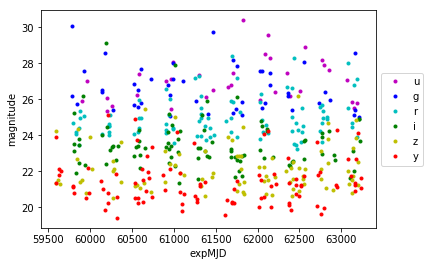

In [121]:
# Plot light curve
color_dict = {'u': 'm', 'g': 'b', 'r': 'c', 'i': 'g', 'z': 'y', 'y': 'r'}
for bp in 'ugrizy':
    times = sample_lc.loc[sample_lc['filter']==bp]['expMJD'].values
    fluxes = sample_lc.loc[sample_lc['filter']==bp]['apFlux'].values
    mags = units.flux_to_mag(fluxes, from_unit='nMgy')
    plt.plot(times, mags, color_dict[bp] + '.', label=bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('magnitude')
plt.xlabel('expMJD')